# Práctica 4. Algoritmo PageRank de Google


Los algoritmos de búsqueda en la web, como el **algoritmo PageRank de Google**, constituyen excelentes aplicaciones del álgebra matricial. PageRank es el método de cálculo utilizado por los fundadores de Google, Sergey Brin y Lawrence Page, durante su doctorado en Stanford en 1996 para clasificar las páginas web de acuerdo con su grado de importancia. 


El objetivo del método es obtener un vector, el vector PageRank, que proporciona la importancia de las páginas. Es decir, asigna, a cada página web, un "grado de importancia", ordenando todas las páginas de acuerdo con dicho grado. Este vector se calcula a partir de la estructura de las conexiones (enlaces) entre las páginas web. Vamos a describir aquí solo los aspectos básicos del método de PageRank, sin entrar en las modificaciones y mejoras que se han realizado (y se siguen realizando actualmente).


Modelizaremos la World Wide Web (que es una colección de páginas web conectadas mediante enlaces) por medio de un grafo dirigido cuyos vértices se corresponden con las páginas y cuyos arcos representan los enlaces entre ellas. Para una mejor comprensión del proceso que vamos a explicar a continuación, en lugar de trabajar con la totalidad de la WWW, consideraremos
como modelo simplificado una pequeña red de páginas que hemos obtenido tras realizar cierta búsqueda en internet. Supongamos que el siguiente grafo dirigido representa los enlaces existentes entre ellas, donde la flecha doble debe ser interpretada como dos arcos, uno en cada sentido.


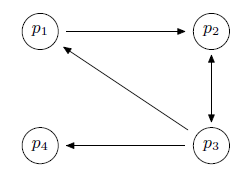


Trabajaremos bajo dos suposiciones que son las ideas clave del algoritmo:


- La importancia de una cierta página $p_i$ (denotada por $I(p_i)$) debe aumentar cada vez que recibe un enlace desde otra página $p_j$ y además el incremento debe ser directamente proporcional al "grado de importancia" de la página $p_j$.
- La importancia de una página web se reparte por partes iguales entre las páginas a las que envía enlaces. 


Así, por ejemplo, $I(p_2) = I(p_1) + \frac{1}{3}I(p_3)$, pues la página $p_2$ recibe enlaces de las páginas $p_1$ y $p_3$ (luego $I(p_2)$ debe aumentar proporcionalmente a como lo hagan las importancias de dichas páginas) y además $p_3$ reparte su importancia en tres partes iguales (pues envía tres enlaces), recibiendo $p_1$ solamente un tercio de la importancia de $p_3$. En general, la fórmula quedaría como sigue: 


$$ I(p_i) = \displaystyle\sum_{\text{páginas $p_j$ que envían enlaces a $p_i$}} \dfrac{I(p_j)}{a_j},$$


donde $a_j$ es el número de enlaces que envía la página $p_j$. Así, $I(p_3) = I(p_2)$, $I(p_4) = \frac{1}{3}I(p_3)$ y $I(p_1) = \frac{1}{3}I(p_3)$. El video que viene en el siguiente enlace (en inglés) te ayudará a entender todo esto: 
http://www.youtube.com/watch?v=ZstQKxUW7oM


En forma matricial, las igualdades anteriores quedarían como sigue: 


$$ \begin{pmatrix} I(p_1)\\ I(p_2)\\ I(p_3) \\ I(p_4) \end{pmatrix} = \begin{pmatrix}0 &0 &\frac{1}{3}& 0\\ 1& 0& \frac{1}{3}& 0\\ 0& 1& 0& 0\\ 0 &0 &\frac{1}{3}& 0  \end{pmatrix} · \begin{pmatrix} I(p_1)\\ I(p_2)\\ I(p_3) \\ I(p_4) \end{pmatrix} \quad \Longrightarrow \quad I=G·I.$$


Así pues, el "vector de importancias" $I$, que es lo que queremos calcular, debe de satisfacer la igualdad $I=G·I$. Por tanto, $I$ debe ser un vector propio de $G$ asociado al valor propio 1. Queremos además que las entradas de $I$ sean no nulas y que estén entre 0 y 1 para poder ordenar correctamente las páginas según su "grado de importancia". Y también queremos que dicho vector $I$ sea único, para no tener dos ordenaciones distintas. Dicho en otras palabras, queremos que $I$ sea el **único vector estacionario de probabilidad** de $G$. Veamos si $G$ posee tal vector.

In [2]:
import numpy as np
from scipy import linalg as la

In [9]:
G=np.array([[0,0,1/3,0],[1,0,1/3,0],[0,1,0,0],[0,0,1/3,0]])
eigval, eigvec = la.eig(G)
print(eigval)

[ 0.        +0.j          0.85138307+0.j         -0.42569154+0.45859189j
 -0.42569154-0.45859189j]


Luego $G$ no tiene al $1$ como autovalor. Por tanto, el único vector $I$ tal que $G·I=I$ es el vector nulo. Sin embargo, podemos modificar ligeramente (y de manera inteligente) la matriz $G$ para forzarla a que posea un vector $I$ con tales características. En particular, recordando un teorema que vimos en la práctica anterior de cadenas de Markov, nos interesa realizar una ligera modificación que convierta a $G$ en una **matriz estocástica regular** (observemos que la matriz anterior no es estocástica, pues la última columna no suma 1).


Las matrices $G$ obtenidas de este tipo de problemas de ordenación de páginas web, por la forma en la que las hemos definido, siempre cumplen que las columnas no nulas suman 1. Sin embargo, pueden existir columnas nulas. Esto ocurre porque hay una página ($p_4$ en nuestro caso) que no envía ningún enlace (se corresponde con un vértice "sumidero" del grafo dirigido). 


La manera más simple de evitar este problema es imaginar que, cuando alguien está navegando a través de la red y llega a una página como esta (sumidero), lo que hace para continuar es elegir una nueva página _totalmente al azar_ . Así pues, podemos pensar que una página sumidero _tiene un enlace_ a cada una de las demás páginas (y a sí misma). Por tanto, podemos redefinir la matriz $G$ sustituyendo las columnas nulas por vectores $(\frac{1}{n}, \frac{1}{n}, \ldots, \frac{1}{n})$, donde $n$ es el número total de páginas. En nuestro caso:


$$ G=\begin{pmatrix}0 &0 &\frac{1}{3}& \frac{1}{4}\\ 1& 0& \frac{1}{3}& \frac{1}{4}\\ 0& 1& 0& \frac{1}{4}\\ 0 &0 &\frac{1}{3}& \frac{1}{4}  \end{pmatrix},$$


luego ya tenemos que $G$ es una matriz estocástica. Veamos si es además regular (a primera vista, no lo sabemos).

In [10]:
G=np.array([[0,0,1/3,1/4],[1,0,1/3,1/4],[0,1,0,1/4],[0,0,1/3,1/4]])

from numpy.linalg import matrix_power as mpow 

print(mpow(G,2))
print(mpow(G,3))
print(mpow(G,4))     

[[0.         0.33333333 0.08333333 0.14583333]
 [0.         0.33333333 0.41666667 0.39583333]
 [1.         0.         0.41666667 0.3125    ]
 [0.         0.33333333 0.08333333 0.14583333]]
[[0.33333333 0.08333333 0.15972222 0.140625  ]
 [0.33333333 0.41666667 0.24305556 0.28645833]
 [0.         0.41666667 0.4375     0.43229167]
 [0.33333333 0.08333333 0.15972222 0.140625  ]]
[[0.08333333 0.15972222 0.18576389 0.17925347]
 [0.41666667 0.24305556 0.34548611 0.31987847]
 [0.41666667 0.4375     0.28298611 0.32161458]
 [0.08333333 0.15972222 0.18576389 0.17925347]]


Luego hemos tenido suerte y sí que se cumple que $G$ es una matriz estocástica regular. Sin embargo, esta no es la situación habitual, aunque vamos a ver que también podremos arreglarlo a través de otra ligera modificación para conseguir que siempre exista un único vector estacionario de probabilidad.


Supongamos que de vez en cuando (e independientemente de si la página visitada en ese momento es un sumidero o no), un usuario de la WWW quiere navegar a una dirección aleatoria en lugar de "seguir" los enlaces de la página web actual. Es decir, podría "querer seguir", en lugar de la matriz $G$, la siguiente matriz denominada **matriz de aleatoriedad**:


$$ E=\begin{pmatrix}\frac{1}{4} &\frac{1}{4} &\frac{1}{4}& \frac{1}{4}\\\frac{1}{4} &\frac{1}{4} &\frac{1}{4}& \frac{1}{4}\\ \frac{1}{4} &\frac{1}{4} &\frac{1}{4}& \frac{1}{4}\\ \frac{1}{4} &\frac{1}{4} &\frac{1}{4}& \frac{1}{4} \end{pmatrix}.$$


Esto significa que cuando se sigue esta matriz, todas las páginas web tienen la misma probabilidad de ser elegidas. Finalmente, asumamos que cada vez que un usuario visita una página web tiene dos posibilidades para actuar: navegar a través de la matriz $G$ (es decir, continuar usando uno de los enlaces de la página web en la que se encuentra) o bien a través de la matriz de aleatoriedad $E$ (es decir, elegir una página web al azar).


Fijemos un número real $\alpha\in ]0, 1[$ que denote la probabilidad de navegar a través de la matriz $G$. Entonces, la probabilidad de navegar siguiendo $E$ es de $1-\alpha$. Como estamos interesados en dar mucha más importancia a la matriz
$G$ que a la matriz $E$, entonces $\alpha$ debería ser un valor cercano a 1 (Brin y Page eligieron un valor de $\alpha$ próximo a $0.85$). Esta nueva situación equivale a considerar, en lugar de la matriz $G$, esta otra matriz:

$$ H = \alpha·G + (1-\alpha)·E.$$


Es fácil comprobar que $H$ es estocástica y que, además, todas sus entradas son estrictamente positivas, luego es regular. Por tanto, existe un vector $I$ satisfaciendo las condiciones requeridas. Este es el vector PageRank que estábamos buscando. 

In [11]:
H=0.85*G+0.15*1/4*np.ones((4,4))      # creamos la matriz H con alpha=0.85 y buscamos un autovector asociado al 1
eigval, eigvec = la.eig(H)
print(np.round(eigval,3))
print(np.round(eigvec,3))             # el primer vector propio es el asociado al valor propio 1

[ 1.   +0.j    -0.319+0.373j -0.319-0.373j -0.   +0.j   ]
[[ 0.325+0.j    -0.273-0.192j -0.273+0.192j  0.   +0.j   ]
 [ 0.602+0.j    -0.218+0.383j -0.218-0.383j -0.196+0.j   ]
 [ 0.652+0.j     0.764+0.j     0.764-0.j    -0.588+0.j   ]
 [ 0.325+0.j    -0.273-0.192j -0.273+0.192j  0.784+0.j   ]]


In [12]:
v=eigvec[:,0:1]
print(v)        # es vector estacionario, pero no de probabilidad: para ello, dividimos entre la suma de las entradas         

[[0.32546017+0.j]
 [0.60210131+0.j]
 [0.6523997 +0.j]
 [0.32546017+0.j]]


In [13]:
I=v/np.sum(v)
print(I)

[[0.17080745+0.j]
 [0.31599379+0.j]
 [0.3423913 +0.j]
 [0.17080745+0.j]]


Por tanto, la página web más importante es la 3, seguido de la 2, y finalmente la 1 y la 4 (estas dos últimas indistintamente de su orden). En este caso ha sido muy sencillo ordenar las páginas "a mano", pero en el caso que tuviésemos muchas páginas web podríamos usar el comando `np.argsort(I)`, el cual nos devuelve las posiciones de los valores de `I` en orden creciente (`I` debe ser un vector fila).

In [12]:
w=np.array([[0.01604717],[0.01210046],[0.03822705],[0.01567622],[0.07658036],[0.07731643],[0.01440049],[0.02947871],
            [0.03892605],[0.03496579],[0.0221931],[0.02435812],[0.11350014],[0.04553457],[0.06196172],[0.10091244],
            [0.09958315],[0.09478533],[0.0179557],[0.06549703]])

print(w)

# supongamos que el vector w es el resultado del algoritmo PageRank de 20 páginas web determinadas y vamos a ordenarlas

print(np.argsort(w.T))      

# luego la página 13 (la posición 13 del vector) sería la más importante

[[0.01604717]
 [0.01210046]
 [0.03822705]
 [0.01567622]
 [0.07658036]
 [0.07731643]
 [0.01440049]
 [0.02947871]
 [0.03892605]
 [0.03496579]
 [0.0221931 ]
 [0.02435812]
 [0.11350014]
 [0.04553457]
 [0.06196172]
 [0.10091244]
 [0.09958315]
 [0.09478533]
 [0.0179557 ]
 [0.06549703]]
[[ 1  6  3  0 18 10 11  7  9  2  8 13 14 19  4  5 17 16 15 12]]


### 1. Ejercicios


1. Un estudiante de segundo de bachillerato de la Comunitat Valenciana está pensando qué universidad elegir para continuar sus estudios. Para ello, va a realizar una búsqueda de información en Google con la palabra clave EDEM. Supongamos que la red de páginas web que están relacionadas con dicha búsqueda y los enlaces entre ellas vienen descritos por el grafo dirigido de la siguiente figura.


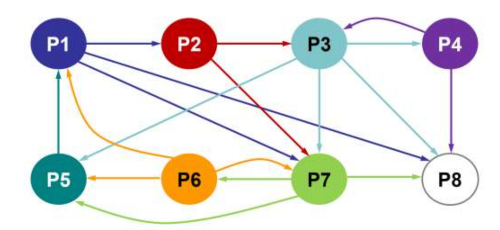


   - Escribe la matriz $H$ asociada a la red, tomando $\alpha=0.85$.
   - Calcula el vector PageRank y ordena las páginas de acuerdo con su grado de importancia. 
   - ¿Cuál será la página web que se mostrará en primer lugar al estudiante?


2. Considera la siguiente matriz estocástica $10\times 10$:

`G=np.array([[0,0,0,0,0,0,0,1/4,0,0],[0,0,0,0,0,0,0,1/4,0,0],[1,1/6,0,1/4,1/2,1,1/3,1/4,1,1/2],[0,0,1/3,0,0,0,0,0,0,0],
             [0,0,1/3,1/4,0,0,0,0,0,0],[0,1/6,0,0,0,0,1/3,0,0,0],[0,1/6,0,0,1/2,0,0,1/4,0,0],[0,1/6,0,1/4,0,0,0,0,0,1/2],
             [0,1/6,1/3,1/4,0,0,0,0,0,0],[0,1/6,0,0,0,0,1/3,0,0,0]])`

   - Supongamos que $G$ es la matriz que describe los enlaces entre 10 páginas web que hemos obtenido tras realizar una búsqueda en Google. Dibuja un diagrama del grafo asociado.
   - Calcula la matriz $H$ (tomando $\alpha = 0.85$) y calcula el vector PageRank.
   - ¿Cuál es la página con mayor PageRank? ¿Podrías indicar una razón sencilla por la que esto sucede?